# Introduction to Echo State Network (ESN)

This introduction is highly inspired from [1, 2].

- [1] https://github.com/reservoirpy/reservoirpy/blob/master/examples/Introduction%20%20to%20Reservoir%20Computing/Introduction_to_RC.ipynb
- [2] Lukoševičius, Mantas. “A Practical Guide to Applying Echo State Networks.” Neural Networks: Tricks of the Trade (2012).

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

import numpy as np
import matplotlib.pyplot as plt


## Echo State Network

Echo State Networks (ESNs) are applied to supervised temporal machine learning tasks where for a given training
input signal $x(n)$ a desired target output signal $y^{target}(n)$ is known. Here $n=1, ..., T$ is the discrete time and 
$T$ is the number of data points in the training dataset. 

The task is
to learn a model with output $y(n)$, where $y(n)$ matches $y^{target}(n)$ as well as possible, minimizing an error measure 
$E(y, y^{target})$, and, more importantly,
generalizes well to unseen data. 

ESNs use an RNN type with leaky-integrated discrete-time continuous-value
units. The typical update equations are 

$$
\hat{h}(n) = \tanh(W^{in} x(n) + W^{rec}h(n-1) + W^{fb}y(n-1) + b^{rec}) \\
h(n) = (1 - \alpha) x(n-1)+\alpha \hat{h}(n)
$$

where $h(n)$ is a vector of reservoir neuron activations, $W^{in}$ and $W^{rec}$ 
are the input and recurrent weight matrices respectively, and $\alpha \in (0, 1]$ 
is the leaking rate. 
The model is also sometimes used without
the leaky integration, which is a special case of $\alpha=1$. 

The linear readout layer is defined as

$$
y(n) = W^{out} h(n) + b^{out}
$$

where $y(n)$ is network output, $W^{out}$ the output weight
matrix, and $b^{out}$ is the output bias. 

An additional nonlinearity can be applied to $y(n)$, 
as well as feedback connections $W^{fb}$ from $y(n-1)$ to $\hat{h}(n)$. 

A graphical representation of
an ESN illustrating our notation and the idea for training is depicted in the following figure. 

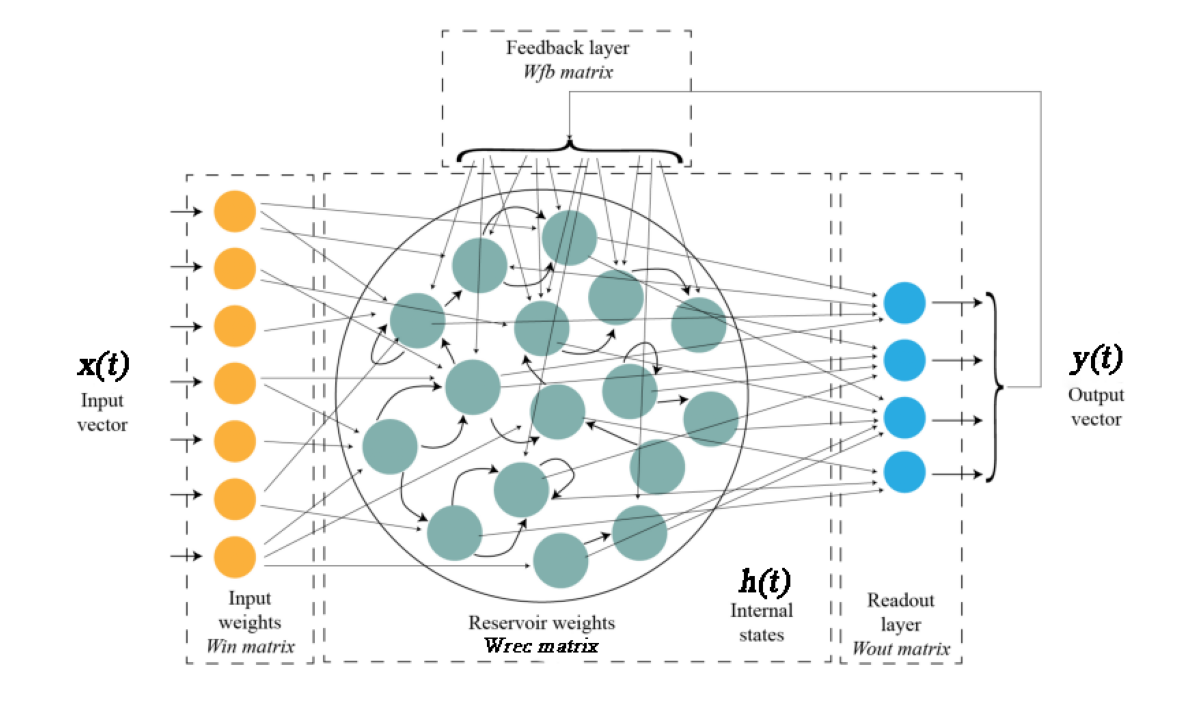

In [2]:
im = plt.imread("../images/esn.png")
plt.figure(figsize=(15, 15))
plt.imshow(im)
plt.axis('off')
plt.show()

### Weight initialization

In [3]:
class InputOrFeedbackWeight(bp.init.Initializer):
  """Generate input or feedback weights for the reservoir."""

  def __init__(self, scale=1., seed=None, prob=0.1, method='uniform'):
    self.rng = bm.random.RandomState(seed)
    self.scale = scale
    self.prob = prob
    self.method = method

  def __call__(self, size):
    if self.method == 'uniform':
      weights = self.rng.uniform(-self.scale, self.scale, size)
    elif self.method == 'normal':
      weights = self.rng.normal(scale=self.scale, size=size)
    elif self.method == 'bimodal':
      dist = self.rng.bernoulli(p=0.5, size=size)
      weights = bm.ones(size) * self.scale
      weights[dist] = -self.scale
    else:
      raise ValueError
    weights[self.rng.random(size) > self.prob] = 0.
    return weights

In [4]:
class RecurrentWeights(bp.init.Initializer):
  """Generate the weights matrix that will be used
    for the internal connections of the reservoir."""

  def __init__(self, scale=1., seed=None, prob=0.1, method='normal', spectral_radius=None):
    self.scale = scale
    self.prob = prob
    self.method = method
    self.rng = bm.random.RandomState(seed)
    self.spectral_radius = spectral_radius

  def __call__(self, size):
    assert size[0] == size[1] + 1, '"size" must be the shape of [weights + bias]'

    if self.method == 'uniform':
      weights = self.rng.uniform(-self.scale, self.scale, size)
    elif self.method == 'normal':
      weights = self.rng.normal(scale=self.scale, size=size)
    else:
      raise ValueError
    weights[self.rng.random(size) > self.prob] = 0.
    if self.spectral_radius is not None:
      current_sr = max(abs(bm.linalg.eig(weights[:-1])[0]))
      weights[:-1] *= self.spectral_radius / current_sr
    return weights

### Ridge regression

Finding the optimal weights $W^{out}$ that minimize the squared error between
$y(n)$ and $y^{target}(n)# amounts to solving a typically overdetermined system of
linear equations

$$Y^{target} = W^{out}X$$

Probably the most universal and stable solution is
ridge regression, also known as regression with Tikhonov regularization:

$$W^{out} = Y^{target}X^T(XX^T+\beta I)^{-1}$$

In [5]:
class LearningRule(bp.layers.Module):
  def update(self, *args, **kwargs):
    raise NotImplementedError

In [6]:
class RidgeRegression(LearningRule):
  """Ridge regression model for reservoir output weights learning."""

  def __init__(self, beta=0.):
    super(RidgeRegression, self).__init__()
    self.beta = beta

  def update(self, inputs, targets):
    inputs = bm.hstack([inputs, bm.zeros([inputs.shape[0], 1])])
    temp1 = bm.dot(inputs.T, inputs)
    temp2 = bm.dot(inputs.T, targets)
    if self.beta > 0.:
      temp1 += self.beta * bm.eye(inputs.shape[1])
    return bm.linalg.solve(temp1, temp2)

### ESN implementation

The following code is the corresponding implementation of ESN model. 

In [7]:
class ESN(bp.layers.Module):
  """Echo state network."""

  def __init__(self, num_in, num_rec, num_out, alpha=1.,
               w_in=InputOrFeedbackWeight(), w_rec=RecurrentWeights(),
               w_out=bp.init.Normal(), w_fb=None,
               noise_in=0., noise_rec=0., noise_out=0.,
               rec_activation='tanh', fb_activation='identity', out_activation='identity',
               learning_rule=RidgeRegression(beta=1e-6)):
    super(ESN, self).__init__()

    # parameters
    self.noise_in = noise_in
    self.noise_rec = noise_rec
    self.noise_out = noise_out
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out
    self.alpha = alpha
    self.rec_activation = bm.activations.get(rec_activation)
    self.fb_activation = bm.activations.get(fb_activation)
    self.out_activation = bm.activations.get(out_activation)
    assert isinstance(learning_rule, LearningRule)
    self.learning_rule = learning_rule

    # weights
    self.w_in = self.init_param(w_in, (num_in, num_rec))
    self.w_fb = self.init_param(w_fb, (num_out, num_rec))
    self.w_rec = self.init_param(w_rec, (num_rec + 1, num_rec))  # recurrent weights + bias
    w_out = self.init_param(w_out, (num_rec + 1, num_out))  # output weights + bias
    self.w_out = bm.TrainVar(w_out)  # we need to train output weights, therefore declare it as a TrainVar

    # variables
    self.rng = bm.random.RandomState()
    self.x = bm.Variable(bm.zeros(num_in))
    self.h = bm.Variable(bm.zeros(num_rec))
    self.y = bm.Variable(bm.zeros(num_out))

  def cell(self, x, h, y=None):
    # add inputs
    if self.noise_in > 0.:
      x += self.noise_in * self.rng.uniform(-1, 1, x.shape)
    hidden = bm.dot(x, self.w_in)
    # add feedback
    if self.w_fb is not None:
      y = self.fb_activation(y)
      if self.noise_out:
        y += self.noise_out * self.rng.uniform(-1, 1, y.shape)
      hidden += bm.dot(y, self.w_fb)
    # add recurrent
    hidden += bm.dot(bm.hstack([h, 1]), self.w_rec)
    hidden = self.rec_activation(hidden)
    if self.noise_rec > 0.:
      hidden += self.noise_rec * self.rng.uniform(-1, -1, h.shape)
    # new state
    h = (1 - self.alpha) * h + self.alpha * hidden
    return h

  def readout(self, h):
    y = bm.dot(bm.hstack([h, 1]), self.w_out)
    return self.out_activation(y)

  def predict(self, inputs, reset_state=False):
    def update(x):
      self.h.value = self.cell(x, self.h, self.y)
      self.y.value = self.readout(self.h)

    if reset_state:
      self.h[:] = 0.
    return bm.make_loop(update, dyn_vars=self.vars(), out_vars=[self.h, self.y])(inputs)

  def train(self, inputs, targets):
    def update(xy):
      x, y = xy
      self.h.value = self.cell(x, self.h, y)

    self.h[:] = 0.
    hs = bm.make_loop(update, dyn_vars=self.vars(), out_vars=self.h)(
      [inputs, bm.vstack([bm.zeros(targets.shape[1]), targets[:-1]])])
    self.w_out.value = self.learning_rule.update(hs, targets)

  def generate(self, warming_inputs, num_generation, reset_state=False):
    def update(_):
      self.h.value = self.cell(self.y, self.h, self.y)
      self.y.value = self.readout(self.h.value)

    warming_hs, warming_ys = self.predict(warming_inputs, reset_state=reset_state)
    f = bm.make_loop(update, dyn_vars=self.vars(), out_vars=[self.h, self.y])
    gen_hs, gen_ys = f(bm.arange(num_generation))
    return (warming_hs, warming_ys), (gen_hs, gen_ys)

## Dataset

Mackey-Glass equation are a set of delayed differential equations describing the temporal behaviour of different physiological signal, for example, the relative quantity of mature blood cells over time.

The equations are defined as:

$$ \frac{dP(t)}{dt} = \frac{\beta P(t - \tau)}{1 + P(t - \tau)^n} - \gamma P(t) $$

where $\beta = 0.2$, $\gamma = 0.1$, $n = 10$, and the time delay $\tau = 17$. $\tau$ controls the chaotic behaviour of the equations (the higher it is, the more chaotic the timeserie becomes. $\tau=17$ already gives good chaotic results.)

In [8]:
def plot_mackey_glass_series(ts, x_series, x_tau_series, num_sample):
  plt.figure(figsize=(13, 5))

  plt.subplot(121)
  plt.title(f"Timeserie - {num_sample} timesteps")
  plt.plot(ts[:num_sample], x_series[:num_sample], lw=2, color="lightgrey", zorder=0)
  plt.scatter(ts[:num_sample], x_series[:num_sample], c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$t$")
  plt.ylabel("$P(t)$")

  ax = plt.subplot(122)
  ax.margins(0.05)
  plt.title(f"Phase diagram: $P(t) = f(P(t-\\tau))$")
  plt.plot(x_tau_series[: num_sample], x_series[: num_sample], lw=1, color="lightgrey", zorder=0)
  plt.scatter(x_tau_series[:num_sample], x_series[: num_sample], lw=0.5, c=ts[:num_sample], cmap="viridis", s=6)
  plt.xlabel("$P(t-\\tau)$")
  plt.ylabel("$P(t)$")
  cbar = plt.colorbar()
  # cbar.ax.set_ylabel('$t$', rotation=270)
  cbar.ax.set_ylabel('$t$')

  plt.tight_layout()
  plt.show()

An easy way to get Mackey-Glass time-series data is using ``brainpy.dataset.mackey_glass_series()``. 
If you want to see the details of the implementation, please see the coressponding source code. 

In [9]:
dt = 0.1
mg_data = bp.datasets.mackey_glass_series(25000, dt=dt, tau=17, beta=0.2, gamma=0.1, n=10, inits=1.2, seed=123)

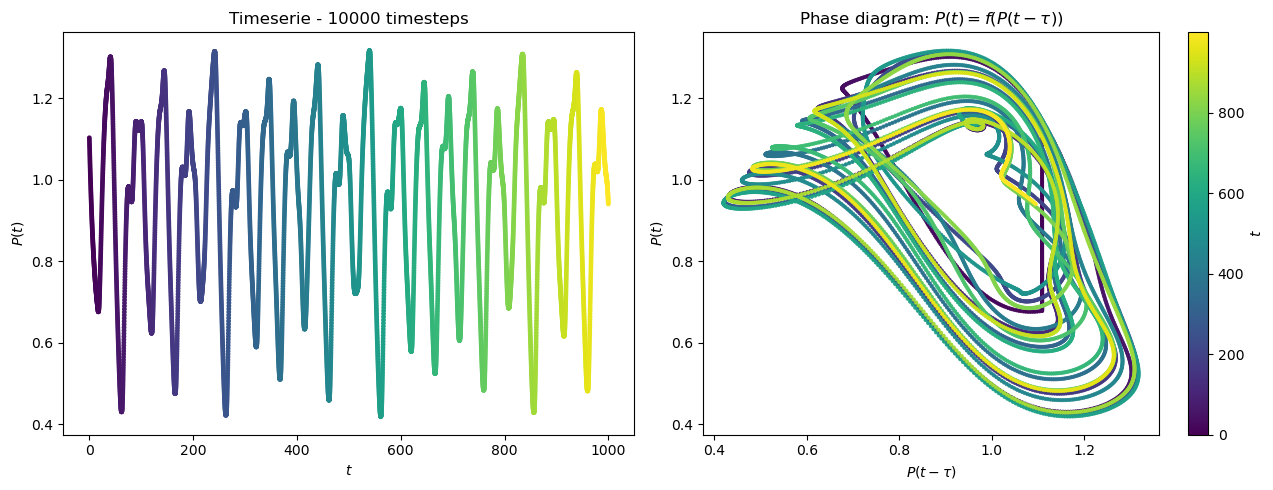

In [10]:
plot_mackey_glass_series(mg_data['ts'], mg_data['x'], mg_data['x_tau'], num_sample=int(1000 / dt))

## Task 1: prediction of Mackey-Glass timeseries

Predict $P(t+1), \cdots, P(t+N)$ from $P(t)$.

### prepare the data

In [11]:
forecast = int(10 / dt)  # predict 10 s ahead
train_length = int(20000 / dt)
sample_rate = int(1 / dt)

X_train = mg_data['x'][:train_length:sample_rate]
Y_train = mg_data['x'][forecast: train_length + forecast: sample_rate]
X_test = mg_data['x'][train_length: -forecast: sample_rate]
Y_test = mg_data['x'][train_length + forecast::sample_rate]

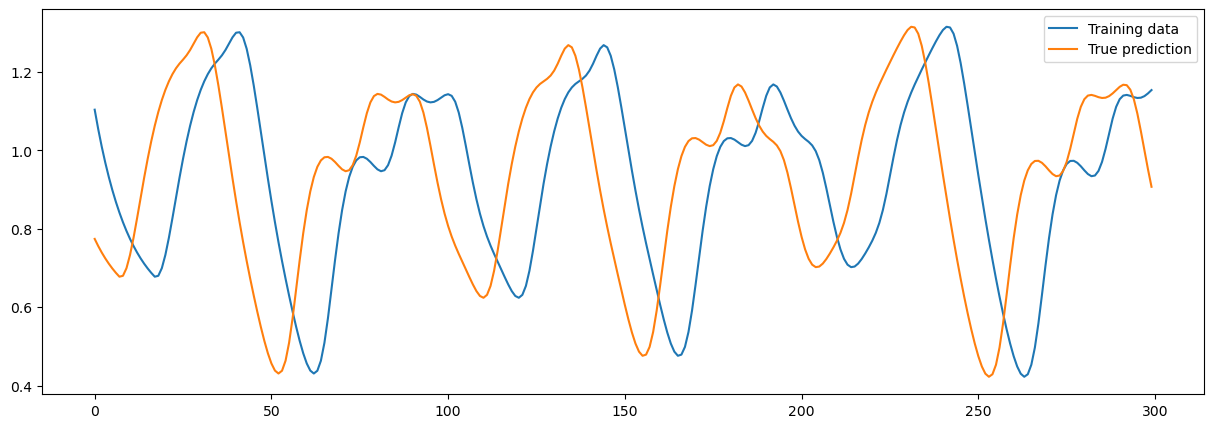

In [12]:
sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(Y_train[:sample], label="True prediction")
plt.legend()
plt.show()

### prepare the ESN

In [13]:
esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=0.3,
          w_in=InputOrFeedbackWeight(method='bimodal', scale=1., prob=0.2, seed=123),
          w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=1.25, seed=123),
          w_out=bp.init.Normal(),
          learning_rule=RidgeRegression(beta=1e-8))

### train and test ESN

In [14]:
esn.train(bm.asarray(X_train), bm.asarray(Y_train))

Test the training data.

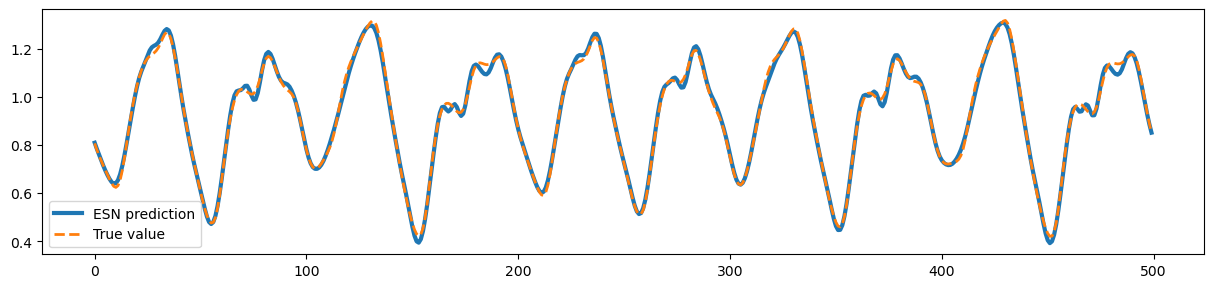

In [15]:
_, ys_predict = esn.predict(X_train, reset_state=True)

start, end = 100, 600
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(), ys_predict.numpy()[start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(), Y_train[start:end, 0], linestyle="--", lw=2, label="True value")
plt.legend()
plt.show()

Test the testing data.

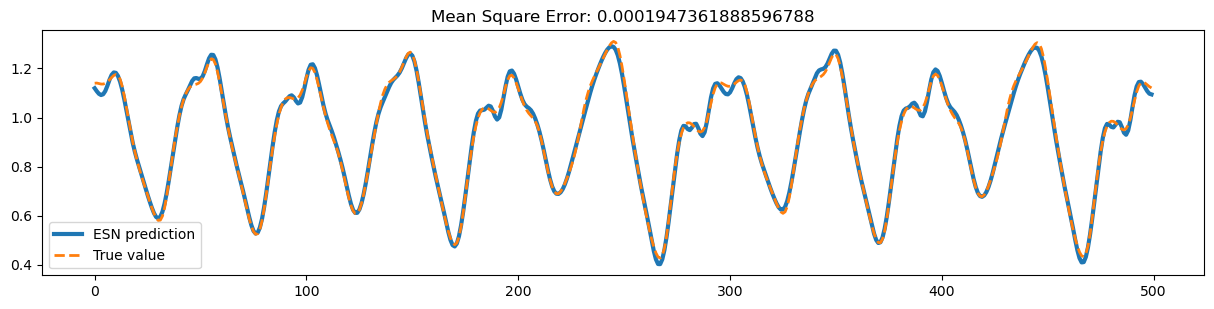

In [16]:
_, ys_predict = esn.predict(X_test)

start, end = 100, 600
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(), ys_predict.numpy()[start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(), Y_test[start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bm.losses.mean_squared_error(ys_predict.numpy(), Y_test)}')
plt.legend()
plt.show()

### make the task harder

In [17]:
forecast = int(50 / dt)  # predict 50 s ahead
train_length = int(20000 / dt)
sample_rate = int(1 / dt)

X_train = mg_data['x'][:train_length:sample_rate]
Y_train = mg_data['x'][forecast: train_length + forecast: sample_rate]
X_test = mg_data['x'][train_length: -forecast: sample_rate]
Y_test = mg_data['x'][train_length + forecast::sample_rate]

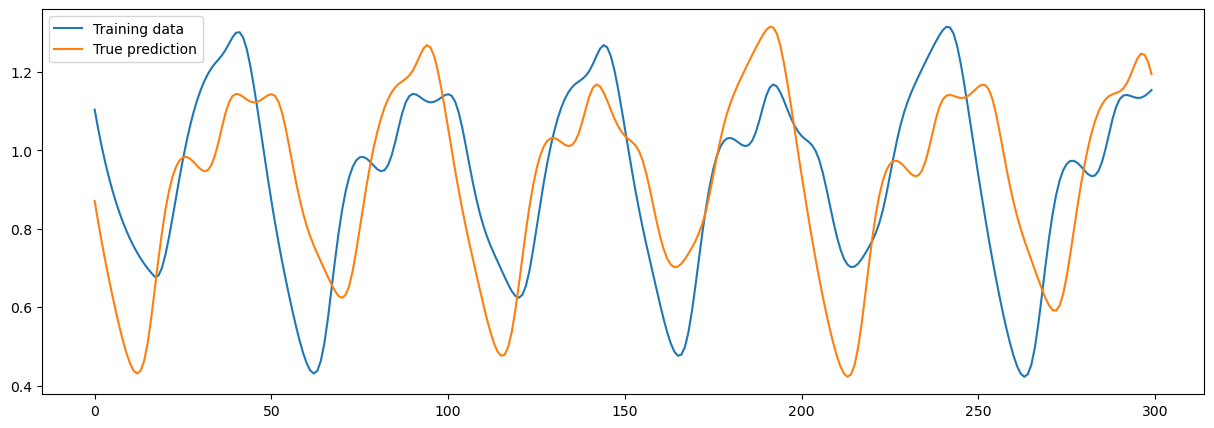

In [18]:
sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(Y_train[:sample], label="True prediction")
plt.legend()
plt.show()

In [19]:
esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=0.3,
          w_in=InputOrFeedbackWeight(method='bimodal', scale=1., prob=0.2, seed=123),
          w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=1.25, seed=123),
          w_out=bp.init.Normal(),
          learning_rule=RidgeRegression(beta=1e-8))

In [20]:
esn.train(bm.asarray(X_train), bm.asarray(Y_train))

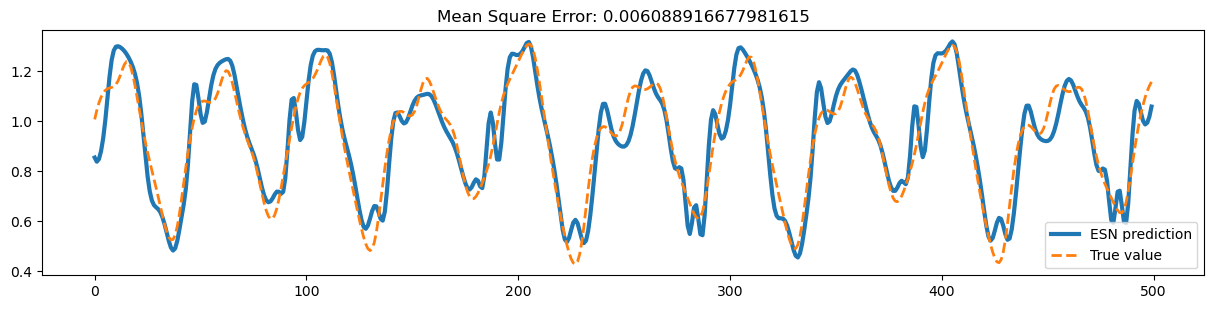

In [21]:
_, ys_predict = esn.predict(X_test, reset_state=False)

start, end = 100, 600
fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(), ys_predict.numpy()[start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(), Y_test[start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bm.losses.mean_squared_error(ys_predict.numpy(), Y_test)}')
plt.legend()
plt.show()

### diving into the reservoir

Let's have a look at the effect of some of the hyperparameters of the ESN.

#### Spectral radius

The spectral radius is defined as the maximum eigenvalue of the reservoir matrix.

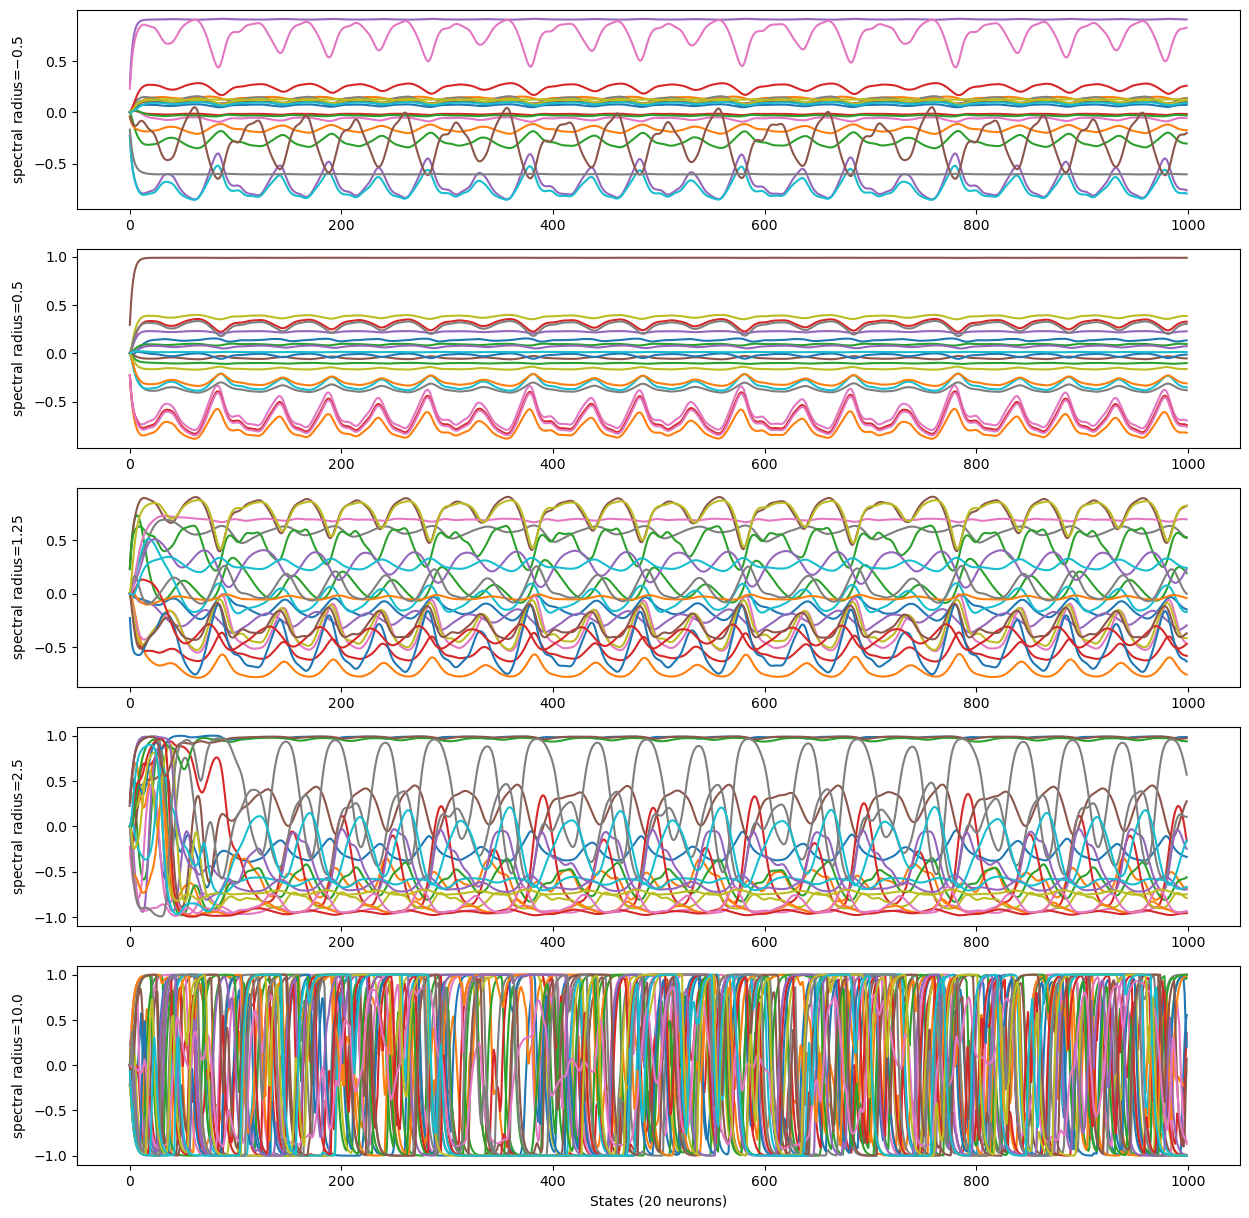

In [22]:
num_sample = 20
all_radius = [-0.5, 0.5, 1.25, 2.5, 10.]

plt.figure(figsize=(15, len(all_radius) * 3))
for i, s in enumerate(all_radius):
  esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=0.3,
            w_in=InputOrFeedbackWeight(method='bimodal', scale=1., prob=0.2),
            w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=s))
  states, _ = esn.predict(bm.asarray(X_test[:1000]))

  plt.subplot(len(all_radius), 1, i + 1)
  plt.plot(states[:, :num_sample])
  plt.ylabel(f"spectral radius=${all_radius[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()


- spectral radius < 1 $\rightarrow$ **stable** dynamics

- spectral radius > 1 $\rightarrow$ **chaotic** dynamics

In most cases, it should have a value around $1.0$ to ensure the *echo state property* (ESP): the dynamics of the reservoir should not be bound to the initial state chosen, and remains close to chaos.

This value also heavily depends on the input scaling.


#### Input scaling

The input scaling controls how the ESN interact with the inputs. It is a coefficient appliyed to the input matrix $W^{in}$.


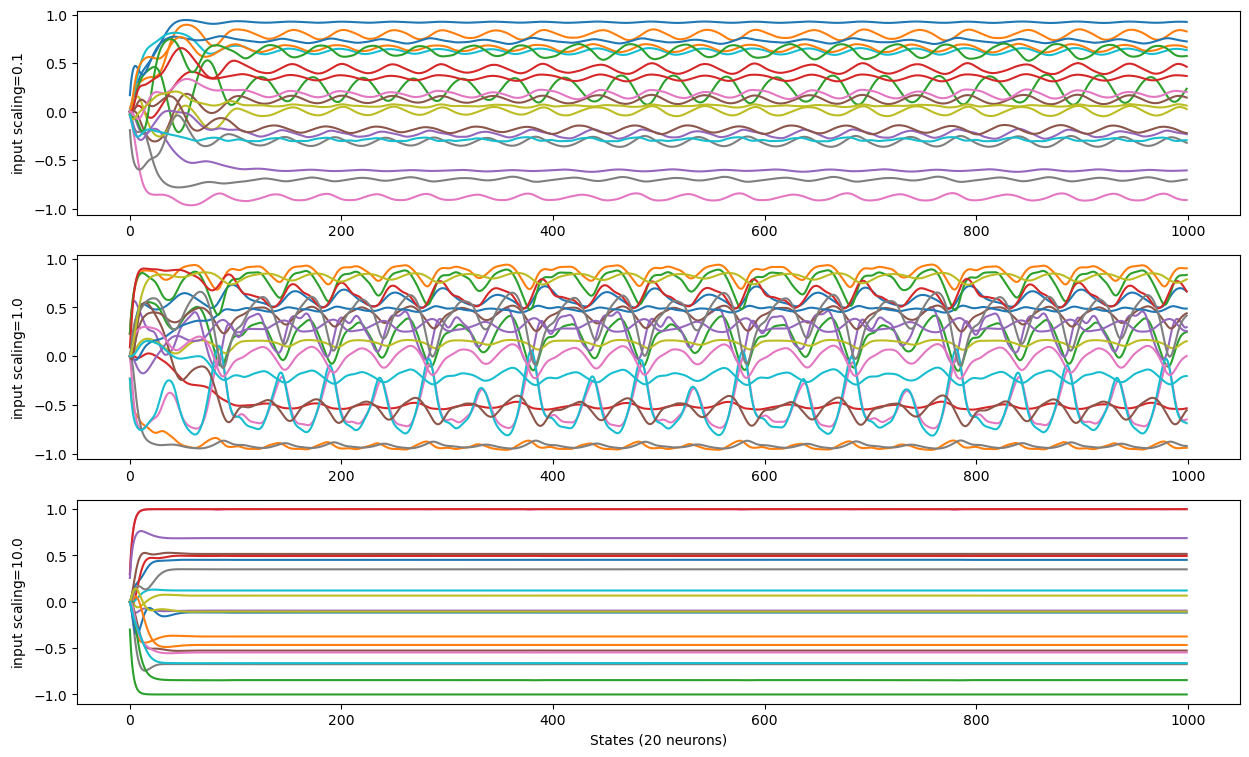

In [23]:
num_sample = 20
all_input_scaling = [0.1, 1.0, 10.0]

plt.figure(figsize=(15, len(all_input_scaling) * 3))
for i, s in enumerate(all_input_scaling):
  esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=0.3,
            w_in=InputOrFeedbackWeight(method='bimodal', scale=s, prob=0.2),
            w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=1.25))
  states, _ = esn.predict(bm.asarray(X_test[:1000]))

  plt.subplot(len(all_input_scaling), 1, i + 1)
  plt.plot(states[:, :num_sample])
  plt.ylabel(f"input scaling=${all_input_scaling[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

#### Leaking rate

The leaking rate ($\alpha$) controls the "memory feedback" of the ESN. The ESN states are indeed computed as:

$$
h(t+1) =  \underbrace{\color{red}{(1 - \alpha)} h(t)}_{\text{previous states}} + \underbrace{\color{red}\alpha f(x(t+1), h(t))}_{\text{new states}}
$$

where $h$ is the state, $x$ is the input data, $f$ is the ESN model function, defined as:

$$ f(x, h) = \tanh(W^{in} \cdotp x + W^{rec} \cdotp h) $$

$\alpha$ must be in $[0, 1]$.

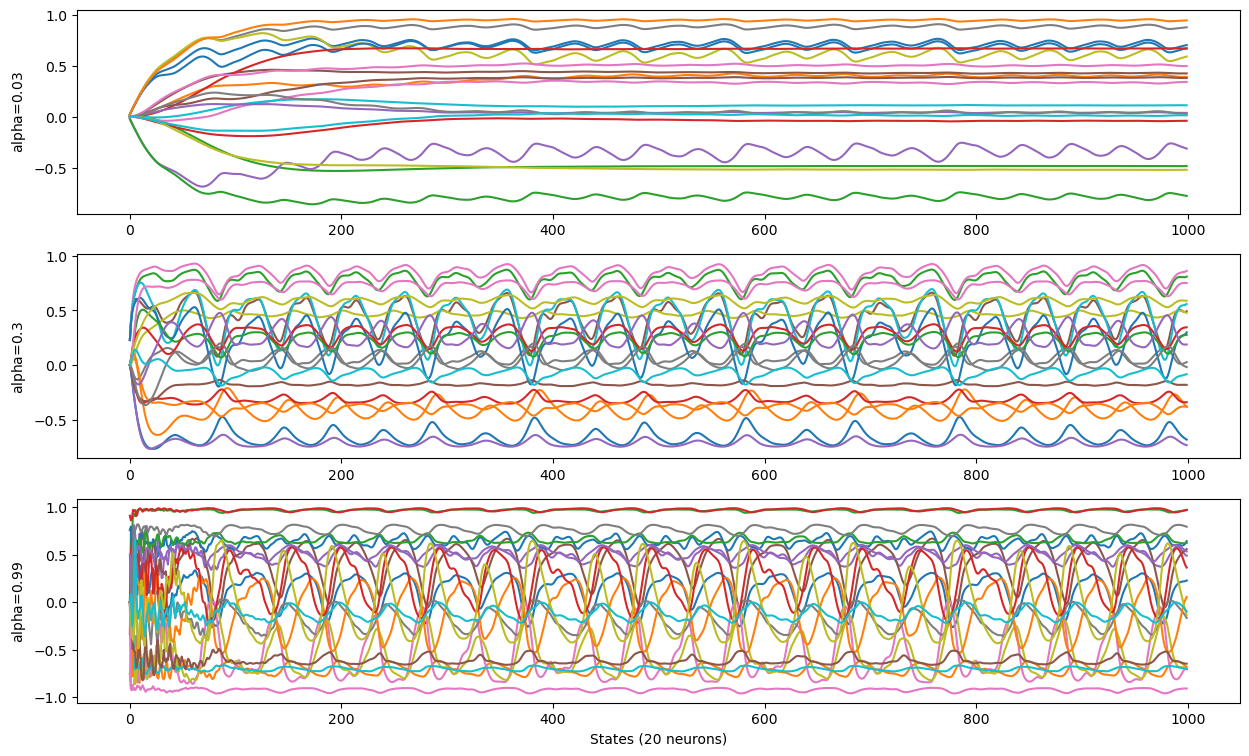

In [24]:
num_sample = 20
all_rates = [0.03, 0.3, 0.99]

plt.figure(figsize=(15, len(all_rates) * 3))
for i, s in enumerate(all_rates):
  esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=s,
            w_in=InputOrFeedbackWeight(method='bimodal', scale=1., prob=0.2),
            w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=1.25))
  states, _ = esn.predict(bm.asarray(X_test[:1000]))

  plt.subplot(len(all_rates), 1, i + 1)
  plt.plot(states[:, :num_sample])
  plt.ylabel(f"alpha=${all_rates[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

Let's reduce the input influence to see what is happening inside the reservoir (input scaling set to 0.2):

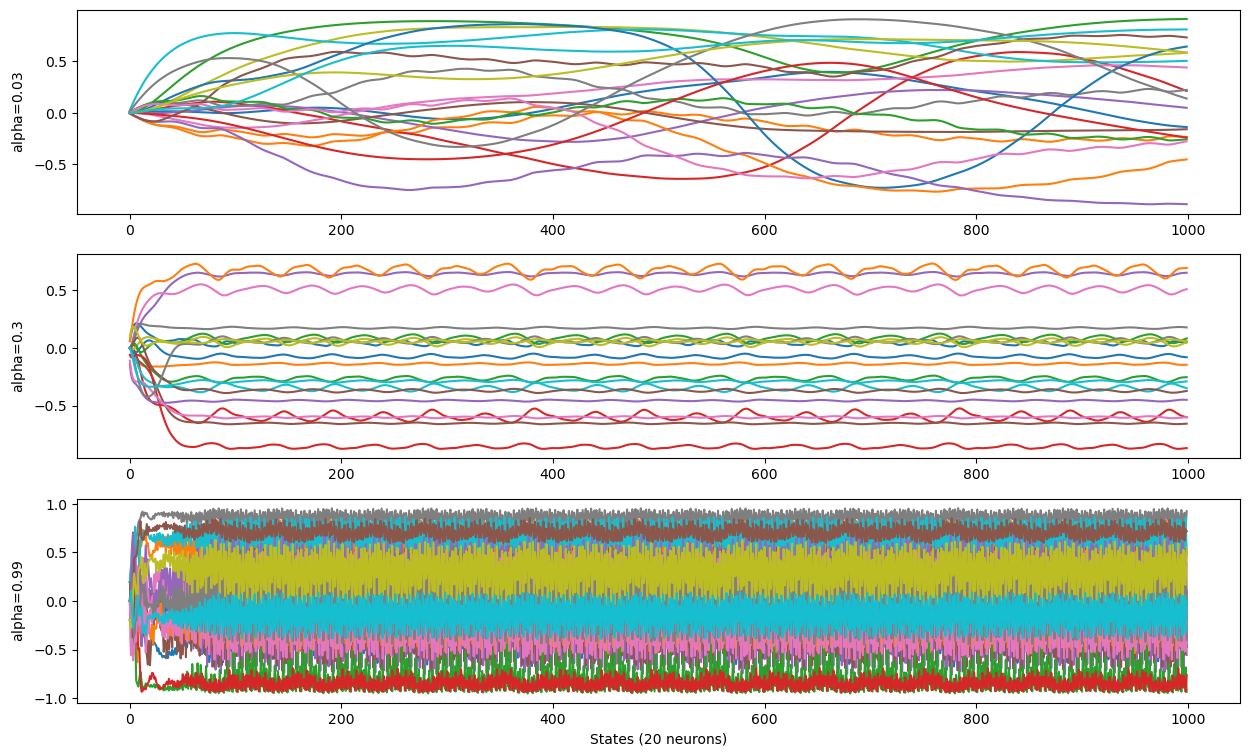

In [25]:
num_sample = 20
all_rates = [0.03, 0.3, 0.99]

plt.figure(figsize=(15, len(all_rates) * 3))
for i, s in enumerate(all_rates):
  esn = ESN(num_in=1, num_rec=100, num_out=1, alpha=s,
            w_in=InputOrFeedbackWeight(method='bimodal', scale=0.2, prob=0.2),
            w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=1.25))
  states, _ = esn.predict(bm.asarray(X_test[:1000]))

  plt.subplot(len(all_rates), 1, i + 1)
  plt.plot(states[:, :num_sample])
  plt.ylabel(f"alpha=${all_rates[i]}$")
plt.xlabel(f"States ({num_sample} neurons)")
plt.show()

- high leaking rate $\rightarrow$ **low inertia**, little memory of previous states
- low leaking rate $\rightarrow$ **high inertia**, big memory of previous states

The leaking rate can be seen as the inverse of the reservoir's time contant.


## Task 2: generation of Mackey-Glass timeseries

Generative mode: the output of ESN will be used as the input. 

During this task, the ESN is trained to make a short forecast of the timeserie (1 timestep ahead). Then, it will be asked to run on its own outputs, trying to predict its own behaviour.

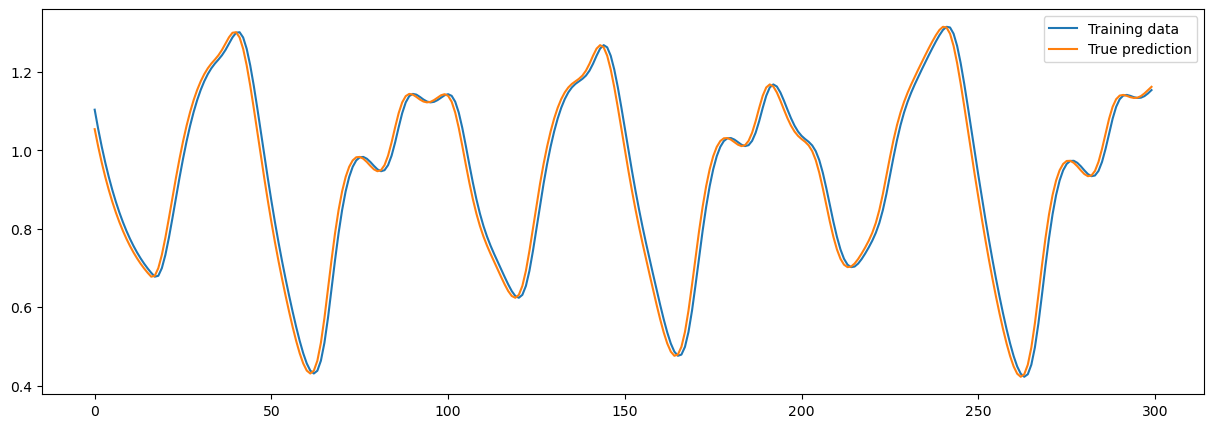

In [26]:
forecast = int(1. / dt)  # predict 1 s ahead
train_length = int(20000 / dt)
sample_rate = int(1 / dt)

X_train = mg_data['x'][:train_length:sample_rate]
Y_train = mg_data['x'][forecast: train_length + forecast: sample_rate]
X_test = mg_data['x'][train_length: -forecast: sample_rate]
Y_test = mg_data['x'][train_length + forecast::sample_rate]

sample = 300
fig = plt.figure(figsize=(15, 5))
plt.plot(X_train[:sample], label="Training data")
plt.plot(Y_train[:sample], label="True prediction")
plt.legend()
plt.show()

In [27]:
esn2 = ESN(num_in=1, num_rec=500, num_out=1, alpha=0.3,
           w_in=InputOrFeedbackWeight(method='uniform', scale=.4, prob=0.5, seed=12345),
           w_rec=RecurrentWeights(method='normal', prob=0.1, spectral_radius=0.5, seed=12345),
           learning_rule=RidgeRegression(1e-8))

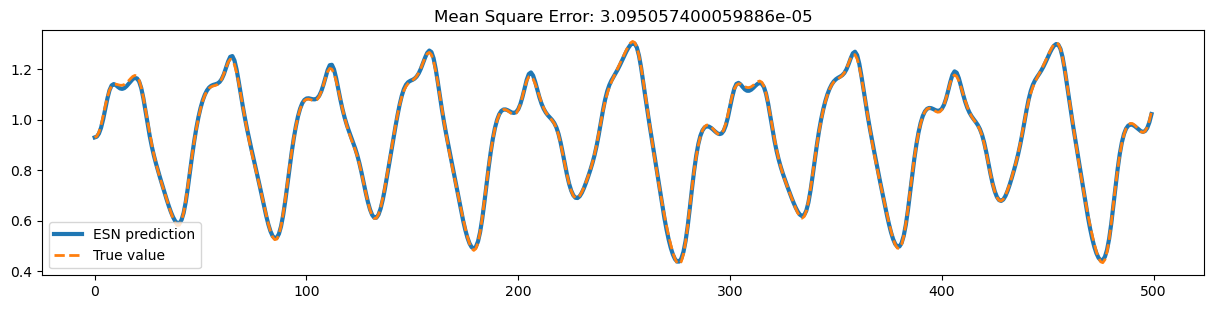

In [28]:
esn2.train(bm.asarray(X_train), bm.asarray(Y_train))

_, ys_predict = esn2.predict(X_test)

start, end = 100, 600
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(bm.arange(end - start).numpy(), ys_predict.numpy()[start:end, 0], lw=3, label="ESN prediction")
plt.plot(bm.arange(end - start).numpy(), Y_test[start:end, 0], linestyle="--", lw=2, label="True value")
plt.title(f'Mean Square Error: {bm.losses.mean_squared_error(ys_predict.numpy(), Y_test)}')
plt.legend()
plt.show()

In [35]:
def plot_generation(gen_ys, real_ys, warming_xs, warming_ys, num_gen, num_seed):
  plt.figure(figsize=(15, 5))
  plt.plot(np.arange(num_gen) + num_seed, gen_ys, label="Generated timeseries")
  plt.plot(np.arange(num_gen) + num_seed, real_ys, linestyle="--", label="Real timeseries")
  plt.plot(np.arange(num_seed), warming_ys, color="lightgray", label="Warming outputs")
  plt.plot(np.arange(num_seed), warming_xs, linestyle="--", label="Warming inputs")
  plt.fill_between([0, num_seed], *plt.ylim(), facecolor='lightgray', alpha=0.5, label="Warming")
  plt.plot([], [], ' ', label=f"$NRMSE = {round(float(bm.losses.mean_squared_error(real_ys, gen_ys)), 4)}$")
  plt.legend(bbox_to_anchor=[1.005, 1], frameon=False)
  plt.show()

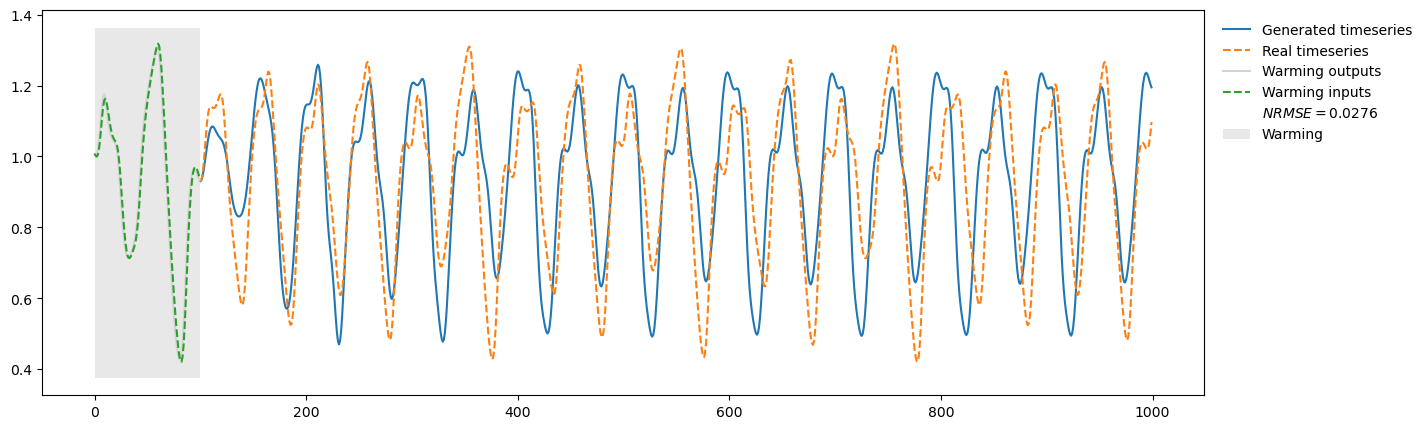

In [36]:
start, num_seed, num_generation = 0, 100, 900

_ = esn2.predict(X_train, reset_state=True)
warming_inputs = X_test[start:start + num_seed]
real_ys = Y_test[start + num_seed: start + num_generation + num_seed]

(_, warming_ys), (_, gen_ys) = esn2.generate(bm.asarray(warming_inputs),
                                             num_generation, 
                                             reset_state=False)

plot_generation(gen_ys, real_ys, warming_inputs, warming_ys.numpy(), num_generation, num_seed)

## References

- Jaeger, H.: The “echo state” approach to analysing and training recurrent neural
  networks. Technical Report GMD Report 148, German National Research Center
  for Information Technology (2001)
- Lukoševičius, Mantas. “A Practical Guide to Applying Echo State Networks.” Neural Networks: Tricks of the Trade (2012).